In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

/var/folders/_6/fpk79cm53rxgcj2gh5prtww00000gn/T/ipykernel_1927/3336430291.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Download the dataset
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

mnist_data = datasets.MNIST(
    root="data/", train=True, transform=transforms.ToTensor(), download=True
)
dataloader = DataLoader(mnist_data, batch_size=64, shuffle=True)

0.3%

100.0%


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100.0%

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




31.8%

100.0%
100.0%


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
# Check the quantity of the dataset

total_data = 0
total_label = 0

for data, label in dataloader:
    total_data+= data.shape[0]
    total_label+=label.shape[0]
    

print("Total data # {} ".format(total_data))
print("Total label # {} ".format(total_label))
print("The shape of the dataset # {} ".format(data.shape))

Total data # 60000 
Total label # 60000 
The shape of the dataset # torch.Size([32, 1, 28, 28]) 


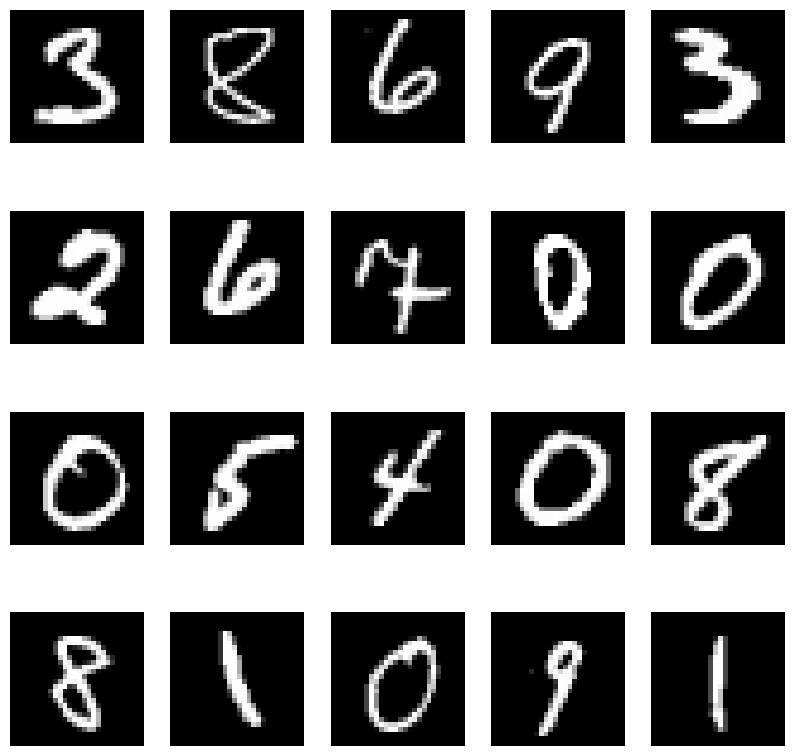

In [9]:
# Display some of the datasets

plt.figure(figsize=(10, 10))

data, label = next(iter(dataloader))
data = data[0:20]

for index, digit in enumerate(data):
    plt.subplot(4, 5, index+1)
    plt.imshow(digit.reshape(28, 28), cmap="gray")
    plt.axis("off")

plt.show()

In [92]:
class Generator(nn.Module):
    """
    A deep convolutional generative adversarial network (DCGAN) generator module.

    This class implements a generator as part of a DCGAN, using a series of transposed convolutional layers to generate images from random noise. It is designed to be used in generative tasks where the goal is to produce realistic images.

    Parameters:
    - latent_space (int): Dimensionality of the latent space (random noise vector). Default is 100.

    The architecture of the generator is as follows:
    1. Transposed Convolutional Layer: Expands the input latent vector into a small feature map.
    2. Batch Normalization: Stabilizes learning by normalizing the input to each activation layer.
    3. ReLU Activation: Introduces non-linearity, allowing the model to generate complex patterns.
    4. Further transposed convolutions, batch normalizations, and ReLU activations: Continue to upscale the feature map to the desired output size.
    5. Tanh Activation: Scales the output to a range of [-1, 1], typical for image data.

    The final output is a single-channel image of the same height and width as the kernel in the last transposed convolutional layer. The output size and quality depend on the parameters of each layer and the complexity of the latent space.

    Example usage:
        # Initialize the generator
        gen = Generator(latent_space=100)

        # Generate a random noise vector
        noise = torch.randn((1, 100, 1, 1))

        # Generate an image
        fake_image = gen(noise)

    Note:
    - This implementation assumes a single-channel output (e.g., grayscale images). For generating RGB images, modify the output channel of the last layer to 3.
    - The quality of generated images heavily depends on the training process and the complexity of the model.

    For more information on DCGANs, refer to the original paper: "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks" by Radford et al.
    """

    def __init__(self, latent_space=100):
        super(Generator, self).__init__()
        self.latent_space = latent_space
        self.model = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=self.latent_space,out_channels=256,kernel_size=4,stride=1,padding=0,bias=False,),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.ConvTranspose2d(
                in_channels=256,out_channels=128,kernel_size=4,stride=2,padding=1,bias=False,),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.ConvTranspose2d(
                in_channels=128,out_channels=64,kernel_size=4,stride=2,padding=1,bias=False,),
            nn.ReLU(),
            
            nn.ConvTranspose2d(
                in_channels=64,out_channels=1,kernel_size=4,stride=2,padding=3,bias=False,),
            nn.Tanh(),
        )

    def forward(self, x):
        if x is not None:
            x = self.model(x)
        else:
            x = "ERROR"
        return x

In [78]:
batch_size = 64
latent_space = 100
num_channel = 1

dataset = torch.randn(batch_size, latent_space, 1, 1)

generator = Generator()
generator(dataset).shape

torch.Size([64, 1, 28, 28])

In [68]:
class Discriminator(nn.Module):
    """
    A deep convolutional generative adversarial network (DCGAN) discriminator module.

    This class implements a discriminator as part of a DCGAN, using a series of convolutional layers to classify images as real or generated (fake). It is designed to be used in generative tasks alongside a generator to produce realistic images.

    The architecture of the discriminator is as follows:
    1. Convolutional Layer: Reduces the spatial dimension and increases the depth of feature maps from the input image.
    2. LeakyReLU Activation: Allows for a small gradient when the unit is not active, preventing dying ReLU problem and helping the gradients to flow through the architecture.
    3. Batch Normalization: Stabilizes learning by normalizing the input to each activation layer.
    4. Further convolutions, leaky ReLUs, and batch normalizations: Continue to process the feature maps.
    5. Fully Connected Layer: Flattens the output and maps it to a single value.
    6. Sigmoid Activation: Outputs a probability indicating how likely the input image is real.

    The discriminator takes a single-channel image (e.g., grayscale) as input and outputs a scalar probability between 0 (fake) and 1 (real).

    Example usage:
        # Initialize the discriminator
        disc = Discriminator()

        # Pass an image (real or generated) to the discriminator
        probability_real = disc(real_image)
        probability_fake = disc(generated_image)

    Note:
    - The discriminator is crucial for the adversarial learning process, guiding the generator to produce more realistic images.
    - The input size to the discriminator must match the output size of the generator.
    - For RGB images, modify the input channel of the first layer to 3.

    This implementation is based on the principles outlined in the DCGAN paper: "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks" by Radford et al.
    """

    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(
                in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(
                in_channels=128, out_channels=256, kernel_size=4, stride=1, padding=0
            ),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(negative_slope=0.2),
        )
        self.out = nn.Sequential(
            nn.Linear(in_features=256 * 4 * 4, out_features=1), nn.Sigmoid()
        )

    def forward(self, x):
        if x is not None:
            x = self.model(x)
            x = x.reshape(x.shape[0], -1)
            x = self.out(x)
        else:
            x = "ERROR"
        return x

In [79]:
batch_size = 64
latent_space = 100
num_channel = 1

dataset = torch.randn(batch_size, num_channel, 28, 28)

discriminator = Discriminator()
discriminator(dataset).shape

torch.Size([64, 1])

In [80]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [81]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [82]:
loss_function = nn.BCELoss()

optimizer_generator = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999)) 

In [87]:
# Train the DCGAN

epochs = 100

for epoch in range(epochs):
    d_loss = []
    g_loss = []
    for index, (real_samples, _) in enumerate(dataloader):
        real_samples = real_samples.to(device)
        batch_size = real_samples.shape[0]
        
        real_labels = torch.ones((batch_size, 1)).to(device)
        fake_labels = torch.zeros((batch_size, 1)).to(device)
        
        noise_data = torch.randn(batch_size, latent_space, 1, 1).to(device)
        fake_samples = generator(noise_data)
        
        real_predicted = discriminator(real_samples)
        fake_predicted = discriminator(fake_samples.detach())
        
        real_loss = loss_function(real_predicted, real_labels)
        fake_loss = loss_function(fake_predicted, fake_labels)
        
        total_loss = real_loss + fake_loss
        
        optimizer_discriminator.zero_grad()
        total_loss.backward()
        optimizer_discriminator.step()
        
        generated_predicted = discriminator(fake_samples)
        generated_loss = loss_function(generated_predicted, real_labels)
        
        optimizer_generator.zero_grad()
        generated_loss.backward()
        optimizer_generator.step()
        
        d_loss.append(total_loss.item())
        g_loss.append(generated_loss.item())
        
    print("Epochs - {}/{} ".format(epoch+1, epochs))
    print("[===========] d_loss: {} - g_loss: {} ".format(np.array(d_loss).mean(), np.array(g_loss).mean()))
        

Epochs - 1/100 
[===========] d_loss: 0.3176629514113736 - g_loss: 3.4125840472698368 
Epochs - 2/100 
[===========] d_loss: 0.3429413336331148 - g_loss: 3.2205634406412336 
Epochs - 3/100 
[===========] d_loss: 0.4089547372115319 - g_loss: 2.961396087906254 
Epochs - 4/100 
[===========] d_loss: 0.4310298822264173 - g_loss: 2.871013543689683 
Epochs - 5/100 
[===========] d_loss: 0.43254334644785825 - g_loss: 2.873204589461975 
Epochs - 6/100 
[===========] d_loss: 0.44032290548499203 - g_loss: 2.9152018117752156 
Epochs - 7/100 
[===========] d_loss: 0.43086090768927704 - g_loss: 2.979964218032894 
Epochs - 8/100 
[===========] d_loss: 0.4293581339945671 - g_loss: 3.003590929387475 
Epochs - 9/100 
[===========] d_loss: 0.40401751012690285 - g_loss: 3.1151560238683658 
Epochs - 10/100 
[===========] d_loss: 0.40215122607598175 - g_loss: 3.1689725609412833 
Epochs - 11/100 
[===========] d_loss: 0.40571515256566787 - g_loss: 3.1953360403079722 
Epochs - 12/100 
[===========] d_loss: 0

In [90]:
noise_data = torch.randn(20, latent_space, 1, 1).to(device)
generated_samples = generator(noise_data)

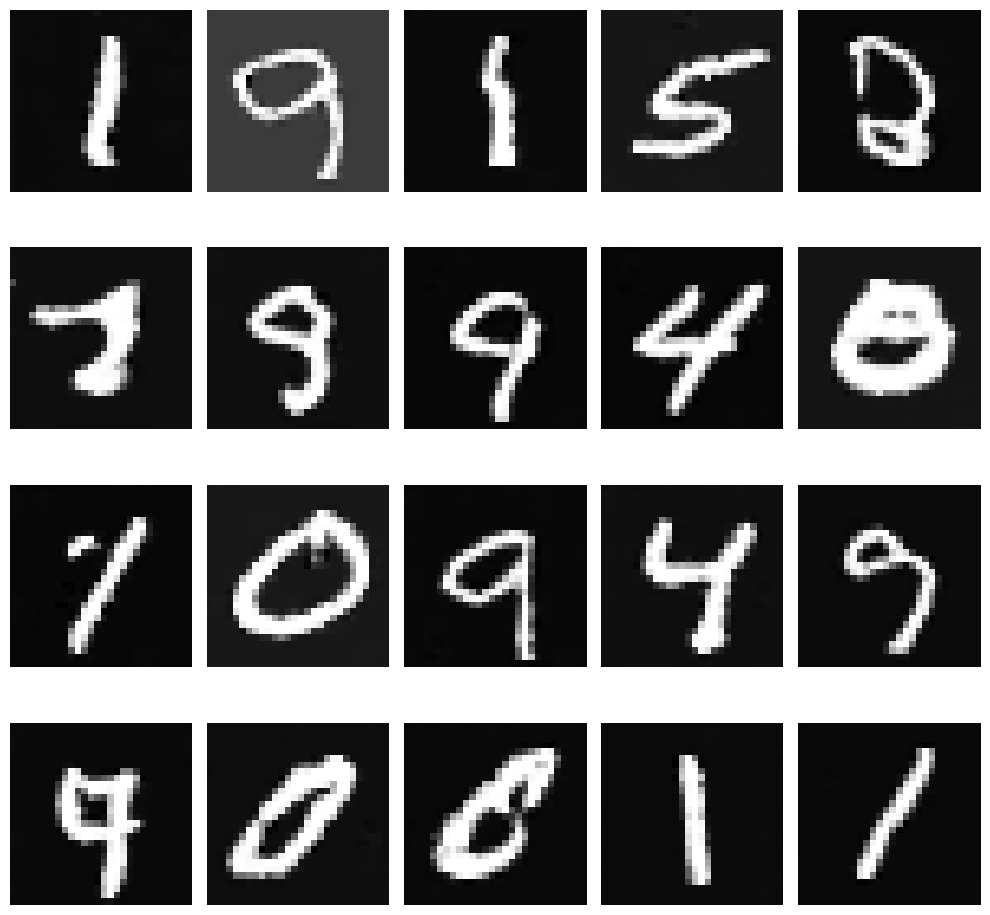

In [91]:
plt.figure(figsize=(10,10))

for index, Image in enumerate(generated_samples):
    plt.subplot(4, 5, index+1)
    plt.imshow(Image.detach().cpu().squeeze(), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()